In [1]:
import numpy as np
import pandas as pd
import warnings

with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.preprocessing.text import Tokenizer
    print('Supressed Warnings..')

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

FAST_RUN = True
IMAGE_WIDTH=50
IMAGE_HEIGHT=50
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Supressed Warnings..


Using TensorFlow backend.


In [2]:
filenames = os.listdir("./canny/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'next':
        categories.append(1)
    elif category == 'prev':
        categories.append(2)
    elif category == 'pause':
        categories.append(3)
    elif category == 'others':
        categories.append(4)

           filename  category
0     prev.1774.png         2
1    pause.3241.png         3
2     prev.1401.png         2
3     prev.1561.png         2
4     next.1145.png         1
5   others.2292.png         4
6   others.2723.png         4
7    pause.2168.png         3
8   others.1314.png         4
9     pause.544.png         3
10     next.966.png         1
11    next.1799.png         1
12     prev.401.png         2
13     prev.485.png         2
14   pause.1138.png         3
15   others.591.png         4
16    pause.299.png         3
17   others.437.png         4
18   pause.3454.png         3
19   pause.1328.png         3


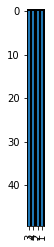

In [3]:
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
print(df.head(20))
df.tail()
df['category'].value_counts().plot.bar()
sample = random.choice(filenames)
image = load_img("./canny/train/"+sample)
plt.imshow(image)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization


In [5]:
from keras import optimizers
model = Sequential()
# ----------------PHASE 0
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

#-----PHASE 1
model.add(Conv2D(32, (2, 2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
  
model.add(Conv2D(32, (2, 2))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
  
model.add(Conv2D(64, (2, 2))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2))) 
  
model.add(Flatten()) 
model.add(Dense(64)) 
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(4)) 
model.add(Activation('sigmoid')) 

#-------PHASE 2
# model.add(Conv2D(6, (3, 3), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))) 
# model.add(Activation('relu')) 
# model.add(MaxPooling2D(pool_size=(2, 2))) 
  
# model.add(Conv2D(32, (2, 2))) 
# model.add(Activation('relu')) 
# model.add(MaxPooling2D(pool_size=(2, 2))) 
  
# model.add(Conv2D(64, (2, 2))) 
# model.add(Activation('relu')) 
# model.add(MaxPooling2D(pool_size=(2, 2))) 
  
# model.add(Flatten()) 
# model.add(Dense(64)) 
# model.add(Activation('relu')) 
# model.add(Dropout(0.5)) 
# model.add(Dense(4)) 
# model.add(Activation('sigmoid')) 

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 49, 49, 32)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 49, 49, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        4128      
_________________________________________________________________
activation_2 (Activation)    (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)      

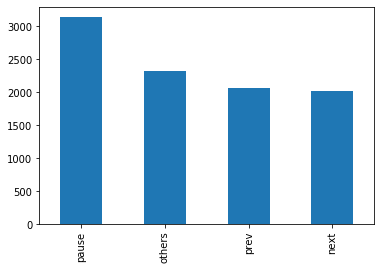

In [6]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]
df["category"] = df["category"].replace({3: 'pause', 1: 'next', 2: 'prev', 4: 'others'})


# 2 - cross validation
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()
validate_df['category'].value_counts().plot.bar()
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32

In [7]:
import cv2
def prepro(img):
    gray_image = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
    print(gray_image.shape)
    return gray_image

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False,
#     vertical_flip=True,
#     preprocessing_function=prepro,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./canny/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./canny/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
) 

# plt.figure(figsize=(12, 12))
# for i in range(0, 15):
#     plt.subplot(5, 3, i+1)
#     for X_batch, Y_batch in example_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

Found 9546 validated image filenames belonging to 4 classes.
Found 2387 validated image filenames belonging to 4 classes.


In [8]:
epochs=10 if FAST_RUN else 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
149/149 [==============================] - 190s 1s/step - loss: 1.0020 - accuracy: 0.5839 - val_loss: 0.2923 - val_accuracy: 0.9215
Epoch 2/10
  1/149 [..............................] - ETA: 8s - loss: 0.6882 - accuracy: 0.7656

/home/karan/.local/lib/python3.6/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


149/149 [==============================] - 12s 81ms/step - loss: 0.4080 - accuracy: 0.8618 - val_loss: 0.0411 - val_accuracy: 0.9789
Epoch 3/10
149/149 [==============================] - 12s 79ms/step - loss: 0.2289 - accuracy: 0.9248 - val_loss: 0.0097 - val_accuracy: 0.9901
Epoch 4/10
149/149 [==============================] - 12s 83ms/step - loss: 0.1443 - accuracy: 0.9535 - val_loss: 0.0223 - val_accuracy: 0.9940
Epoch 5/10
149/149 [==============================] - 13s 85ms/step - loss: 0.1166 - accuracy: 0.9597 - val_loss: 0.0368 - val_accuracy: 0.9927
Epoch 6/10
149/149 [==============================] - 13s 87ms/step - loss: 0.0958 - accuracy: 0.9689 - val_loss: 8.6914e-04 - val_accuracy: 0.9991
Epoch 7/10
149/149 [==============================] - 15s 100ms/step - loss: 0.0846 - accuracy: 0.9725 - val_loss: 0.0042 - val_accuracy: 0.9983
Epoch 8/10
149/149 [==============================] - 130s 871ms/step - loss: 0.0686 - accuracy: 0.9784 - val_loss: 0.0042 - val_accuracy: 0.9

In [14]:
model.save_weights("model.h5")

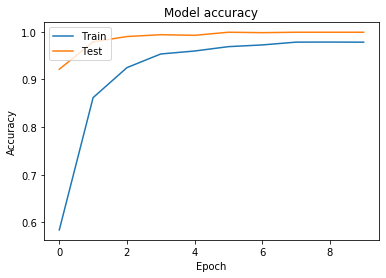

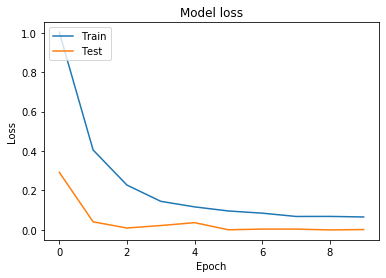

In [15]:
# visualize training
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
# ax1.plot(history.history['loss'], color='b', label="Training loss")
# ax1.plot(history.history['val_loss'], color='r', label="validation loss")
# ax1.set_xticks(np.arange(1, epochs, 1))
# ax1.set_yticks(np.arange(0, 1, 0.1))

# ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
# ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
# ax2.set_xticks(np.arange(1, epochs, 1))

# legend = plt.legend(loc='best', shadow=True)
# plt.tight_layout()
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Found 2790 validated image filenames.
(2790, 1)
(2790, 4)
------------------Testing Data---------------------
             filename category
2772    next.2892.png     next
2773     next.834.png     next
2774    next.2488.png     next
2775    prev.2642.png     prev
2776    prev.1002.png     prev
2777   pause.3142.png   others
2778     next.275.png     next
2779     next.462.png     next
2780    pause.761.png   others
2781    prev.1566.png     prev
2782     next.453.png     next
2783    prev.1431.png     prev
2784   others.492.png   others
2785    next.3088.png     next
2786  others.1006.png   others
2787    next.2250.png     next
2788     next.437.png     next
2789   others.689.png   others


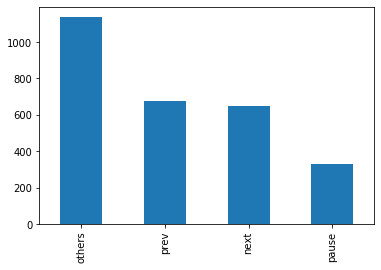

In [16]:
test_filenames = os.listdir('./canny/test1')
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./canny/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
print(test_df.shape)
print(predict.shape)
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
# test_df['category'] = test_df['category'].replace({ 'next': 1, 'pause': 0 })
test_df['category'].value_counts().plot.bar()

sample_test = test_df.tail(18)
print('------------------Testing Data---------------------')
print(sample_test)

In [12]:
import json

model_json = model.to_json()
with open("model_in_json.json", "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights("model_weights.h5")

In [13]:
print(predict[1])
# print(test_df.at(3))

[1.8730164e-03 2.9802322e-08 0.0000000e+00 1.4901161e-07]
